#### 功能说明：
针对一张经过标注的输入图像，对其进行变形操作，得到变形后的原图片和标注图片。

In [51]:
import random
import cv2
import numpy as np
from scipy import misc
from matplotlib import pyplot as plt
%matplotlib inline

#### 参数设定：
+ 输入图像路径；标注图像路径会根据输入图像路径获取
+ 网络参数：包括水平和垂直方向上网格距离（像素为单位）

In [52]:
image_path = "test.png"
hor_interval = 50
ver_interval = 50

In [53]:
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst

In [54]:
def morphTriangle(img1, img2, t1, t2):
    # transform triangle t1 in img1 to triangle t2 in img2

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = []
    t2Rect = []

    for i in range(0, 3):
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))


    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2Rect), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    imgRect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]

    size = (r2[2], r2[3])
    warpImage = applyAffineTransform(imgRect, t1Rect, t2Rect, size)
    
#     Tracer()()

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( 1 - mask ) + warpImage * mask

In [150]:
def getWarp(pts_list_before, height, width, warp_type):
    pts_list_after = []
    
    for pt in pts_list_before:
        x = pt[0]
        y = pt[1]
        if warp_type == "noise":
            x = x + random.gauss(0, 3)
            y = y + random.gauss(0, 2)

        if warp_type == "warp1":
            
            if x > width / 2:
                x = x - (x - width / 2) * 0.1
                y = y + ((x / (width / 2)) - 1) ** 2 * 50

        x = np.min([np.max([0, x]), width - 1])
        y = np.min([np.max([0, y]), height - 1])

        pts_list_after.append((int(x), int(y)))
    return pts_list_after

In [109]:
img = misc.imread(image_path)
height, width, _ = img.shape
# plt.imshow(img)

In [110]:
hor_pts_num = np.round(width / hor_interval)
hor_interval = (width - 1) / hor_pts_num
pts_1 = np.cumsum(np.ones(int(hor_pts_num)) * hor_interval).tolist()
pts_1.insert(0, 0)

In [111]:
pts_1_prime = pts_1[1:]
pts_2 = (np.asarray(pts_1[0:-1]) + np.array(pts_1_prime)) / 2
pts_2 = pts_2.tolist()
pts_2.append(width - 1)
pts_2.insert(0, 0)

In [112]:
even_pts_num = len(pts_1)
odd_pts_num = len(pts_2)
pts_1 = np.round(pts_1)
pts_2 = np.round(pts_2)

In [113]:
ver_pts_num = np.round(height / ver_interval)
ver_interval = (height - 1) / ver_pts_num
pts_v = np.cumsum(np.ones(int(ver_pts_num)) * ver_interval).tolist()
pts_v.insert(0, 0)
pts_v = np.round(pts_v)

In [138]:
pts_list = {}
tri_list = []
tot_pts_num = 0
for v_idx, pt_v in enumerate(pts_v):
    even_line = v_idx % 2 == 0
    pts_h = pts_1 if even_line else pts_2
    cur_pts = []
    for pt_h in pts_h:
        cur_pts.append([pt_v, pt_h])
    pts_list[v_idx] = cur_pts
    
    if v_idx >= 1:
        # construct new triangles
        if even_line:
            # this is the even line
            odd_line_start = tot_pts_num - odd_pts_num
            even_line_start = tot_pts_num
        else:
            # this is the odd line
            odd_line_start = tot_pts_num
            even_line_start = tot_pts_num - even_pts_num

        odd_pt_idx = odd_line_start
        for even_pt_idx in range(even_line_start, even_line_start + even_pts_num):
            tri_1 = [even_pt_idx, odd_pt_idx, odd_pt_idx + 1]
            tri_list.append(tri_1)
            
            if even_pt_idx < even_line_start + even_pts_num - 1:
                tri_2 = [even_pt_idx, even_pt_idx + 1, odd_pt_idx + 1]
                tri_list.append(tri_2)
            
            odd_pt_idx += 1

    tot_pts_num += len(cur_pts)

In [151]:
pts_list_values = list(pts_list.values())
pts_list_before = []
for idx in range(len(pts_list_values)):
    pts_list_before.extend(pts_list_values[idx])
# opencv requires that x is before y
pts_list_before = [(int(pt[1]), int(pt[0])) for pt in pts_list_before]

In [152]:
pts_list_after = getWarp(pts_list_before, height, width, "warp1")

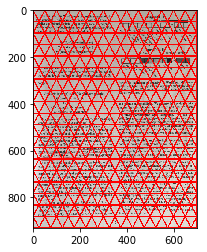

In [153]:
# draw triangle mesh on original image
img_result = np.copy(img)
for tri in tri_list:
    for pt_idx in range(3):
        img_result = cv2.line(img_result,
                              tuple(pts_list_before[tri[pt_idx % 3]]),
                              tuple(pts_list_before[tri[(pt_idx + 1) % 3]]),
                              (255,0,0),
                              3)

plt.imshow(img_result)
misc.imsave('output.png', img_result)

In [154]:
# tri_before = []
# tri_after = []
imgMorph = np.zeros(img.shape, dtype = img.dtype)
for tri in tri_list:
    tri_before = [pts_list_before[tri[0]],
                  pts_list_before[tri[1]],
                  pts_list_before[tri[2]]]

    tri_after = [pts_list_after[tri[0]],
                 pts_list_after[tri[1]],
                 pts_list_after[tri[2]]]
    # Morph one triangle at a time.
    morphTriangle(img, imgMorph, tri_before, tri_after)

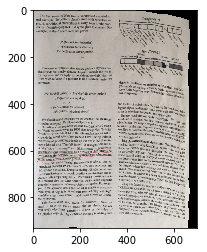

In [155]:
plt.imshow(imgMorph)
misc.imsave('output_morph.png', imgMorph)